In [ ]:
!pip install yfinance

In [10]:
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import pandas as pd

In [5]:
with open("tickers.txt", "r") as file:
    tickers = [line.strip() for line in file]

output_file = "sp500_data.csv"
with open(output_file, "w") as f:
    f.write("Ticker,Date, Volume,Price_Change\n")

for ticker in tickers:
    try:
        print(f"Fetching data for {ticker}...")
        stock = yf.Ticker(ticker)
        index = stock.history(start="2010-01-01", end="2020-12-31")

        if index.empty:
            print(f"No data for {ticker}. Skipping...")
            continue

        expected_days = 252 * 10  # 10 years of trading data
        if len(index) < expected_days:
            print(f"Incomplete data for {ticker} ({len(index)} days). Skipping...")
            continue

        index['Price_Change'] = index['Close'].pct_change()

        index.reset_index(inplace=True)
        index['Ticker'] = ticker
        index[['Ticker', 'Date', 'Volume', 'Price_Change']].to_csv(
            output_file, mode='a', header=False, index=False
        )

    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")
print(f"Data collection complete! Saved to {output_file}.")

Fetching data for EQIX...
Fetching data for STLD...
Fetching data for GPC...
Fetching data for BKNG...
Fetching data for CSX...
Fetching data for AON...
Fetching data for BLK...
Fetching data for TJX...
Fetching data for IRM...
Fetching data for ELV...
Fetching data for ANET...
Incomplete data for ANET (1655 days). Skipping...
Fetching data for LVS...
Fetching data for PCG...
Fetching data for FAST...
Fetching data for GLW...
Fetching data for CNC...
Fetching data for TPR...
Fetching data for CL...
Fetching data for PWR...
Fetching data for FDX...
Fetching data for ROST...
Fetching data for WDC...
Fetching data for V...
Fetching data for AMD...
Fetching data for PM...
Fetching data for NVR...
Fetching data for J...
Fetching data for KDP...
Fetching data for TSLA...
Fetching data for PHM...
Fetching data for HD...
Fetching data for KEYS...
Incomplete data for KEYS (1561 days). Skipping...
Fetching data for LW...
Incomplete data for LW (1041 days). Skipping...
Fetching data for RCL...
Fe

In [7]:
clean_data = pd.read_csv("sp500_data.csv")
print(clean_data.shape)
missing_summary = clean_data.isnull().sum()
print(missing_summary[missing_summary > 0])

# Get unique tickers from the 'Ticker' column
unique_tickers = clean_data['Ticker'].unique()

# Count the number of unique tickers
print(f"Number of unique tickers: {len(unique_tickers)}")

X = clean_data.drop(columns=['Price_Change'])
y = clean_data['Price_Change']
print(X.shape, y.shape)
print(X.head())
print(y.head())

(1219742, 4)
Price_Change    441
dtype: int64
Number of unique tickers: 441
(1219742, 3) (1219742,)
  Ticker                       Date   Volume
0   EQIX  2010-01-04 00:00:00-05:00   576300
1   EQIX  2010-01-05 00:00:00-05:00   681900
2   EQIX  2010-01-06 00:00:00-05:00  1397500
3   EQIX  2010-01-07 00:00:00-05:00   797200
4   EQIX  2010-01-08 00:00:00-05:00   432400
0         NaN
1   -0.009310
2    0.009121
3   -0.020451
4   -0.004846
Name: Price_Change, dtype: float64


In [135]:
data = yf.download("^GSPC", start="2010-01-01", end="2020-12-31")

print(data.head())

index_data = data[["Volume", "Close"]]
index_data['Price_Change'] = index_data['Close'].pct_change()

index_data.to_csv("sp500_index_volume.csv")

print(index_data)

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2010-01-04  1132.989990  1133.869995  1116.560059  1116.560059  3991400000
2010-01-05  1136.520020  1136.630005  1129.660034  1132.660034  2491020000
2010-01-06  1137.140015  1139.189941  1133.949951  1135.709961  4972660000
2010-01-07  1141.689941  1142.459961  1131.319946  1136.270020  5270680000
2010-01-08  1144.979980  1145.390015  1136.219971  1140.520020  4389590000
Price           Volume        Close Price_Change
Ticker           ^GSPC        ^GSPC             
Date                                            
2010-01-04  3991400000  1132.989990          NaN
2010-01-05  2491020000  1136.520020     0.003116
2010-01-06  4972660000  1137.140015     0.000546
2010-01-07  5270680000  1141.689941     0.004001
2010-01-08  4389590000  1144.979980     0.002882
...     


C:\Users\Utku Ayten\AppData\Local\Temp\ipykernel_197704\711515528.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index_data['Price_Change'] = index_data['Close'].pct_change()


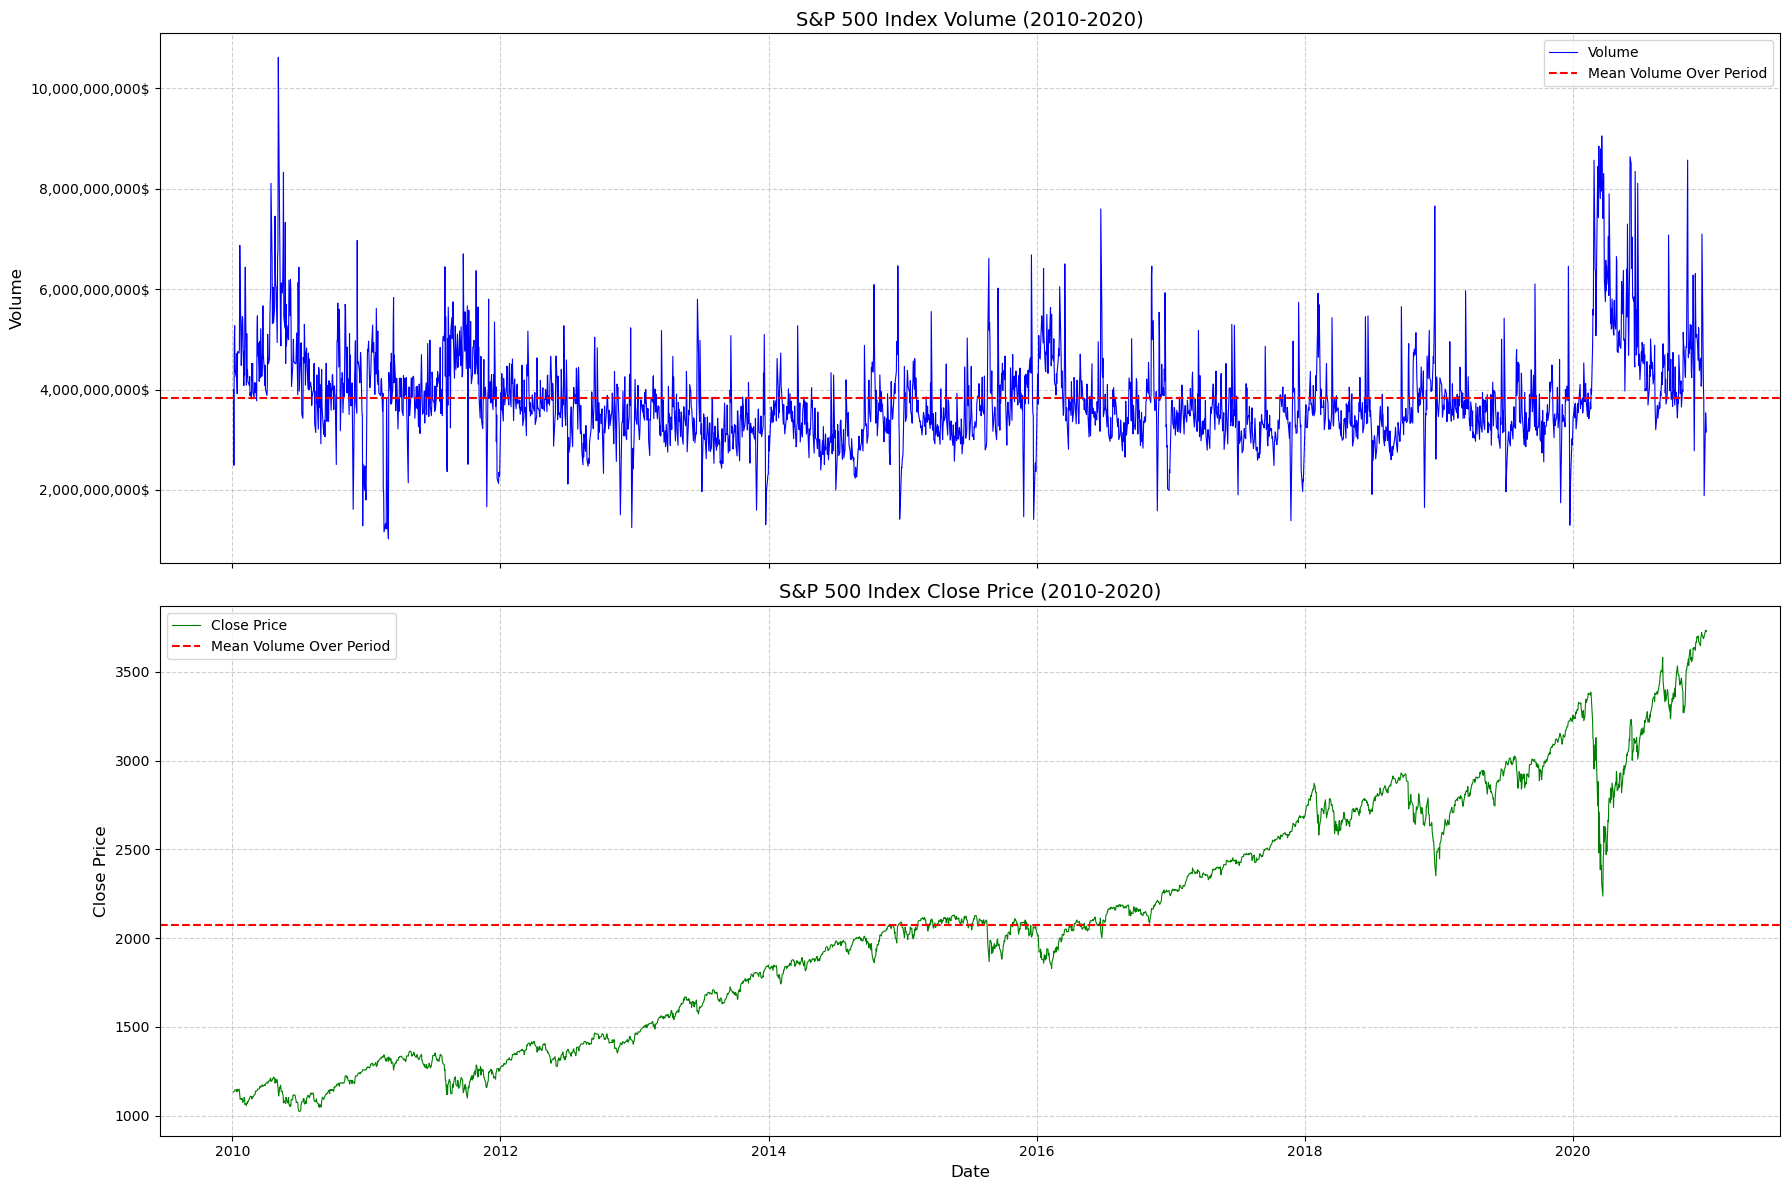

In [127]:
from matplotlib.ticker import FuncFormatter


def format_large_values(x, pos):
    return f'{int(x):,}$'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

ax1.plot(index_data.index, index_data['Volume'].values, label="Volume", linewidth=0.8, color='blue')
ax1.set_title("S&P 500 Index Volume (2010-2020)", fontsize=14)
ax1.set_ylabel("Volume", fontsize=12)
ax1.grid(True, linestyle="--", alpha=0.6)
ax1.yaxis.set_major_formatter(FuncFormatter(format_large_values))
ax1.axhline(y=index_data['Volume'].values.mean(), color='red', linestyle='--', label="Mean Volume Over Period")
ax1.legend()

ax2.plot(index_data.index, index_data['Close'].values, label="Close Price", linewidth=0.8, color='green')
ax2.axhline(y=index_data['Close'].values.mean(), color='red', linestyle='--', label="Mean Volume Over Period")
ax2.set_title("S&P 500 Index Close Price (2010-2020)", fontsize=14)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Close Price", fontsize=12)
ax2.grid(True, linestyle="--", alpha=0.6)
ax2.legend()

plt.tight_layout()
plt.show()

In [130]:
index_data.shape, clean_data.shape

C:\Users\Utku Ayten\AppData\Local\Temp\ipykernel_197704\2763315631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index_data['Price_Change'] = index_data['Close'].pct_change()


((2768, 3), (1219742, 4))

In [131]:
ticker_data = clean_data.pivot(index='Date', columns='Ticker', values=[' Volume', 'Price_Change'])

ticker_data.columns = ['_'.join(col).strip() for col in ticker_data.columns.values]
ticker_data = ticker_data.reset_index()
ticker_data = ticker_data.set_index('Date')

ticker_data.index = ticker_data.index.astype(str).str[:11]
ticker_data.index = pd.to_datetime(ticker_data.index)
index_data.index = pd.to_datetime(index_data.index)


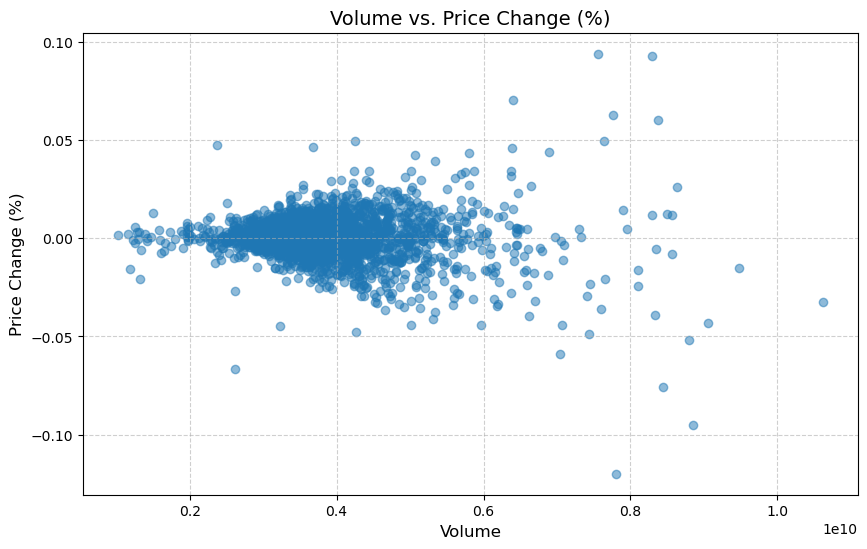

In [134]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(index_data["Volume"], index_data["Price_Change"], alpha=0.5)
plt.title("Volume vs. Price Change (%)", fontsize=14)
plt.xlabel("Volume", fontsize=12)
plt.ylabel("Price Change (%)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

High Volume and High Price Change:

Outliers on the top-right or bottom-right of the graph (large volume with significant price changes) could indicate market-moving events.
Market Stability:

The concentration of points near the origin suggests that most days see stable prices and moderate trading activity.
Event-Driven Volatility:

The outliers (large price changes or unusually high volumes) may help you identify event-driven periods that warrant further investigation.
